In [17]:
"""
1. Loads vocab
2. Builds data generator
3. Builds image caption model
4. Train
4. Eval
"""

import os
import sys
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#from tensorflow import gfile
import pprint
import pickle as pk
import numpy as np
import math

input_description_file = "D:/BaiduNetdiskDownload/Rnn图像语义全部资料/深度学习之神经网络（CNN RNN GAN）算法原理+实战/课程数据/image_caption_data/results_20130124.token"
input_img_feature_dir = "D:/BaiduNetdiskDownload/Rnn图像语义全部资料/深度学习之神经网络（CNN RNN GAN）算法原理+实战/课程数据/image_caption_data/feature_extraction_inception_v3/"
input_vocab_file = "D:/BaiduNetdiskDownload/Rnn图像语义全部资料/深度学习之神经网络（CNN RNN GAN）算法原理+实战/课程数据/image_caption_data/vocab.txt"
output_dir = "D:/BaiduNetdiskDownload/Rnn图像语义全部资料/深度学习之神经网络（CNN RNN GAN）算法原理+实战/课程数据/image_caption_data/local_run"


if not os.path.exists(output_dir):
    os.mkdir(output_dir)

#threshold是门槛的意思，就是过滤掉三次以下频率的词
num_vocab_word_threshold=3,
# 词向量大小
num_embedding_nodes=32,
#步长
num_timesteps=10,
# lstm单元输出维度（又叫输出神经元数）
num_lstm_nodes=[64, 64],
#两层的lstm
num_lstm_layers=2,
#全连接大小
num_fc_nodes=32,
batch_size=50,
#gru rnn lstm可选
cell_type='lstm',
# 控制梯度，梯度上线
clip_lstm_grads=1.0,
#学习率
learning_rate=0.001,
#dropout
keep_prob=0.8,
#每隔多久打印一次log
log_frequent=100,
save_frequent=1000,

Instructions for updating:
non-resource variables are not supported in the long term


#### 词表的构建，之前是统计他的一个词频，现在是把词做一个序号,然后word转id，id转word

In [3]:
class Vocab(object):
    def __init__(self, filename, word_num_threshold):
        #看名字word转id,id转word
        self._id_to_word = {}
        self._word_to_id = {}
        self._unk = -1
        self._eos = -1
        self._word_num_threshold = word_num_threshold
        self._read_dict(filename)

    def _read_dict(self, filename):
        with tf.io.gfile.GFile(filename, 'r') as f:
            lines = f.readlines()
        for line in lines:
            word, occurence = line.strip('\r\n').split('\t')
            occurence = int(occurence)
            #print(type(occurence))
            #print(type(self._word_num_threshold))  tuple元组
            if word != '<UNK>' and occurence < self._word_num_threshold[0]:
                continue
            idx = len(self._id_to_word)
            #unk是用来补0的，这个条件只有开头是满足的
            if word == '<UNK>':
                self._unk = idx
            #如果等于句号
            elif word == '.':
                self._eos = idx
            #如果已经在词表中去了，抛异常
            if idx in self._id_to_word or word in self._word_to_id:
                raise Exception('duplicate words in vocab file')
            
            self._word_to_id[word] = idx
            self._id_to_word[idx] = word

    @property
    def unk(self):
        return self._unk

    @property
    def eos(self):
        return self._eos

    def word_to_id(self, word):
        return self._word_to_id.get(word, self.unk)

    def id_to_word(self, cur_id):
        return self._id_to_word.get(cur_id, '<UNK>')

    def size(self):
        return len(self._word_to_id)

    def encode(self, sentence):
        word_ids = [self.word_to_id(cur_word) for cur_word in sentence.split(' ')]
        return word_ids

    def decode(self, sentence_id):
        words = [self.id_to_word(word_id) for word_id in sentence_id]
        return ' '.join(words)
    

vocab=Vocab(input_vocab_file,num_vocab_word_threshold)
vocab_size=vocab.size()
print("vocab_size: %d" % vocab_size)
    

pprint.pprint(vocab.encode("I have a dream"))
pprint.pprint(vocab.decode([5,10,9,20]))
    


vocab_size: 10875
[1494, 389, 1, 0]
'the of man white'


In [4]:
#直接复制上面的 ，parse是解析的意思 就是解析这个toke_file 看他的参数兄弟,就是把图片对应的描述弄出来
def parse_token_file(token_file):
    """Parses token file."""
    img_name_to_tokens = {}
    with tf.io.gfile.GFile(token_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        img_id, description = line.strip('\r\n').split('\t')
        img_name, _ = img_id.split('#')
        img_name_to_tokens.setdefault(img_name, [])
        img_name_to_tokens[img_name].append(description)
    #返回字典，是全部的图片的全部描述,不懂得全部看下一个cell。dict还有append？那玩意不是list的专属嘛
    return img_name_to_tokens

"""Converts tokens of each description of imgs to id. """
    #就是将每一个描述转成ID
def convert_token_to_id(img_name_to_tokens, vocab):
    #用来存id
    img_name_to_token_ids = {}
    print(type(img_name_to_tokens))
    for img_name in img_name_to_tokens:
        #print(type(img_name))#是一个字符串 全是图片描述，为什么？不是说是转id嘛，全部看下一个cell
        #print(type(img_name_to_tokens))
        img_name_to_token_ids.setdefault(img_name, [])
        descriptions = img_name_to_tokens[img_name]
        #print(type(descriptions)) list 每一个图像的句子
        for description in descriptions:
            token_ids = vocab.encode(description)
            img_name_to_token_ids[img_name].append(token_ids)
    return img_name_to_token_ids

    
img_name_to_tokens = parse_token_file(input_description_file)
img_name_to_token_ids = convert_token_to_id(img_name_to_tokens, vocab)

print("num of all images: %d" % len(img_name_to_tokens))
pprint.pprint(list(img_name_to_tokens.keys())[0:10])
pprint.pprint(img_name_to_tokens['2778832101.jpg'])
print("num of all images: %d" % len(img_name_to_token_ids))
pprint.pprint(list(img_name_to_token_ids.keys())[0:10])
pprint.pprint(img_name_to_token_ids['2778832101.jpg'])

<class 'dict'>
num of all images: 31783
['1000092795.jpg',
 '10002456.jpg',
 '1000268201.jpg',
 '1000344755.jpg',
 '1000366164.jpg',
 '1000523639.jpg',
 '1000919630.jpg',
 '10010052.jpg',
 '1001465944.jpg',
 '1001545525.jpg']
['A man in jeans is reclining on a green metal bench along a busy sidewalk and '
 'crowded street .',
 'A white male with a blue sweater and gray pants laying on a sidewalk bench .',
 'A man in a blue shirt and gray pants is sleeping on a sidewalk bench .',
 'A person is sleeping on a bench , next to cars .',
 'A man sleeping on a bench in a city area .']
num of all images: 31783
['1000092795.jpg',
 '10002456.jpg',
 '1000268201.jpg',
 '1000344755.jpg',
 '1000366164.jpg',
 '1000523639.jpg',
 '1000919630.jpg',
 '10010052.jpg',
 '1001465944.jpg',
 '1001545525.jpg']
[[3, 9, 4, 132, 8, 3532, 6, 1, 48, 337, 146, 139, 1, 244, 93, 7, 380, 36, 2],
 [3, 20, 179, 11, 1, 26, 284, 7, 120, 128, 297, 6, 1, 93, 146, 2],
 [3, 9, 4, 1, 26, 21, 7, 120, 128, 8, 340, 6, 1, 93, 146, 2]

#### 上面的不懂得全部看下一个cell

In [5]:
#dict还有append？那玩意不是list的专属嘛 https://blog.csdn.net/qdPython/article/details/111070698

dict = {'Name': ["chenhaorong"], 'Age': 7, 'Class': 'First'}
 
print ("dict['Name']: ", dict['Name'])
print ("dict['Age']: ", dict['Age'])
dict['Name'].append("love xu")
print ("dict['Name']: ", dict['Name'])
for x in dict:
    print(x)

dict['Name']:  ['chenhaorong']
dict['Age']:  7
dict['Name']:  ['chenhaorong', 'love xu']
Name
Age
Class


In [66]:
#这个是图像与提取的特征加载进来
class ImageCaptionData(object):
    def __init__(self,
                 img_name_to_token_ids,
                 #特征
                 img_feature_dir,
                 #文本对齐
                 num_timesteps,
                 #词表
                 vocab,
                 #是否可以shuffle。看第28行代码
                 deterministic = False):
        self._vocab = vocab
        #所有图片特征的路径（有features）,其实我还是比较好奇地这个pickle的格式（这不就是CPickle嘛）
        self._all_img_feature_filepaths = []
        for filename in tf.compat.v1.gfile.ListDirectory(img_feature_dir):
            #把文件夹和夹下面的文件名拼接起来，并且放到一个list中
            self._all_img_feature_filepaths.append(os.path.join(img_feature_dir, filename))
        pprint.pprint(self._all_img_feature_filepaths)
        
        #img_name_to_token_ids是一个字典，能 查 出每一个图片name对应的描述（不写清楚第二天就忘记）
        self._img_name_to_token_ids = img_name_to_token_ids
        #文本对齐
        self._num_timesteps = num_timesteps
        #开始指标
        self._indicator = 0
        #是否shuffle
        self._deterministic = deterministic
        #存储所有图片的名字
        self._img_feature_filenames = []
        #所有图像的特征向量
        self._img_feature_data = []
        #开始加载特征,函数写在了下面的第39行
        self._load_img_feature_pickle()
        
        if not self._deterministic:
            self._random_shuffle()

    """loads img features data from pickle."""
    def _load_img_feature_pickle(self):
        for filepath in self._all_img_feature_filepaths:
            print("loading %s" % filepath)
            #这里之前一直有问题，要用rb来读，同时写的时候也要用wb来写，
            #https://blog.csdn.net/qq_42372629/article/details/100121516
            with tf.io.gfile.GFile(filepath, 'rb') as f:
                #看下一个cell测试
                #这就是之前看的cpickle,弄到文件中去不就是cpickle.dump。加载进来就是clickle.load
                filenames, features = pk.load(f)
                #把名字和特征添加到全局的图片名字和图片特征中去
                self._img_feature_filenames += filenames
                self._img_feature_data.append(features)
        #[#(1000,1,1,2048),#(1000,1,1,2048)]->#(2000,1,1,2048)         
        self._img_feature_data = np.vstack(self._img_feature_data)
        
        #将上面的4个维度变成3个维度 ，就是中间第三个维度的1去掉
        origin_shape = self._img_feature_data.shape
        self._img_feature_data = np.reshape(
            self._img_feature_data, (origin_shape[0], origin_shape[3]))
        
       #转成numpy的格式
        self._img_feature_filenames = np.asarray(self._img_feature_filenames)
        print(self._img_feature_data.shape)
        print(self._img_feature_filenames.shape)
        if not self._deterministic:
            self._random_shuffle()


    def size(self):
        return len(self._img_feature_filenames)

    #返回每一张图片的维度有多大
    def img_feature_size(self):
        return self._img_feature_data.shape[1]

    #这个和之前的文本分类是一样的
    def _random_shuffle(self):
        p = np.random.permutation(self.size())
        #看标题
        self._img_feature_filenames = self._img_feature_filenames[p]
        self._img_feature_data = self._img_feature_data[p]

        #第121行要用到_img_desc，filenames是特征pickle的名字
    def _img_desc(self, filenames):
        #存储句子转id之后的值
        batch_sentence_ids = []
        #这里看121行
        batch_weights = []
        
        for filename in filenames:
            token_ids_set = self._img_name_to_token_ids[filename]
            # chosen_token_ids = random.choice(token_ids_set)
            chosen_token_ids = token_ids_set[0]
            chosen_token_length = len(chosen_token_ids)
           #全部初始化为1
            weight = [1 for i in range(chosen_token_length)]
            #大于文本对齐的
            #print(type(self._num_timesteps))
            if chosen_token_length >= self._num_timesteps[0]:
                #截断 ,记得self._num_timesteps是元组，要加[0]
                chosen_token_ids = chosen_token_ids[0:self._num_timesteps[0]]
                weight = weight[0:self._num_timesteps[0]]
            else:
                #小就做填充，和之前的是一样的
                remaining_length = self._num_timesteps - chosen_token_length
                #这里没大懂
                chosen_token_ids += [self._vocab.eos for i in range(remaining_length)]
                weight += [0 for i in range(remaining_length)]
            #填充或截断之后加到结果中去
            batch_sentence_ids.append(chosen_token_ids)
            batch_weights.append(weight)
            
        #都转成numpy数组
        batch_sentence_ids = np.asarray(batch_sentence_ids)
        batch_weights = np.asarray(batch_weights)
        return batch_sentence_ids, batch_weights

    """return next batch 返回下一个batch"""
    def next(self, batch_size):
        end_indicator = self._indicator + batch_size
        print(type(self._indicator))
        if end_indicator > self.size():
            if not self._deterministic:
                self._random_shuffle()
            self._indicator = 0
            end_indicator = self._indicator + batch_size
        assert end_indicator <= self.size()#上面是两种情况，一个是if 大于。。。否则断言就是小于
        
        #把特征取出来
        batch_img_features = self._img_feature_data[self._indicator: end_indicator]
        #把特征的名字也取出来
        batch_img_names = self._img_feature_filenames[self._indicator: end_indicator]
        #获得描述的id,这里的batch_weights很那啥，例如我id是[100,101,102,10,3,0,0,0,0]后面的零是为了填充
        #，然后 计算梯度的时候后面就不需要计算了，就用一个batch_weights进行标注，[1,1,1,1,1,0,0,0,0]
        batch_sentence_ids, batch_weights = self._img_desc(batch_img_names)
       #方便下一次取新数据
        self._indicator = end_indicator
        return batch_img_features, batch_sentence_ids, batch_weights, batch_img_names


caption_data = ImageCaptionData(img_name_to_token_ids, input_img_feature_dir, num_timesteps, vocab)

img_feature_dim = caption_data.img_feature_size()
caption_data_size = caption_data.size()

print("img_feature_dim: %d" % img_feature_dim)
print("caption_data_size: %d" % caption_data_size)

#测试一下nextbatch函数
batch_img_features, batch_sentence_ids, batch_weights, batch_img_names = caption_data.next(5)

#然后把上面取出来的值都打印出来
pprint.pprint(batch_img_features)
#打印出来的id和最后的一行word是对应的，我已经查看了
pprint.pprint(batch_sentence_ids)
pprint.pprint(batch_weights)
pprint.pprint(batch_img_names)


['D:/BaiduNetdiskDownload/Rnn图像语义全部资料/深度学习之神经网络（CNN RNN '
 'GAN）算法原理+实战/课程数据/image_caption_data/feature_extraction_inception_v3/image_features-0.pickle',
 'D:/BaiduNetdiskDownload/Rnn图像语义全部资料/深度学习之神经网络（CNN RNN '
 'GAN）算法原理+实战/课程数据/image_caption_data/feature_extraction_inception_v3/image_features-1.pickle',
 'D:/BaiduNetdiskDownload/Rnn图像语义全部资料/深度学习之神经网络（CNN RNN '
 'GAN）算法原理+实战/课程数据/image_caption_data/feature_extraction_inception_v3/image_features-10.pickle',
 'D:/BaiduNetdiskDownload/Rnn图像语义全部资料/深度学习之神经网络（CNN RNN '
 'GAN）算法原理+实战/课程数据/image_caption_data/feature_extraction_inception_v3/image_features-11.pickle',
 'D:/BaiduNetdiskDownload/Rnn图像语义全部资料/深度学习之神经网络（CNN RNN '
 'GAN）算法原理+实战/课程数据/image_caption_data/feature_extraction_inception_v3/image_features-12.pickle',
 'D:/BaiduNetdiskDownload/Rnn图像语义全部资料/深度学习之神经网络（CNN RNN '
 'GAN）算法原理+实战/课程数据/image_caption_data/feature_extraction_inception_v3/image_features-13.pickle',
 'D:/BaiduNetdiskDownload/Rnn图像语义全部资料/深度学习之神经网络（CNN RNN '
 'GAN）算法原理+实战/

loading D:/BaiduNetdiskDownload/Rnn图像语义全部资料/深度学习之神经网络（CNN RNN GAN）算法原理+实战/课程数据/image_caption_data/feature_extraction_inception_v3/image_features-6.pickle
loading D:/BaiduNetdiskDownload/Rnn图像语义全部资料/深度学习之神经网络（CNN RNN GAN）算法原理+实战/课程数据/image_caption_data/feature_extraction_inception_v3/image_features-7.pickle
loading D:/BaiduNetdiskDownload/Rnn图像语义全部资料/深度学习之神经网络（CNN RNN GAN）算法原理+实战/课程数据/image_caption_data/feature_extraction_inception_v3/image_features-8.pickle
loading D:/BaiduNetdiskDownload/Rnn图像语义全部资料/深度学习之神经网络（CNN RNN GAN）算法原理+实战/课程数据/image_caption_data/feature_extraction_inception_v3/image_features-9.pickle
(31783, 2048)
(31783,)
img_feature_dim: 2048
caption_data_size: 31783
<class 'int'>
array([[0.36139914, 0.31446567, 0.17888439, ..., 0.30371705, 0.37401962,
        0.26683325],
       [0.11199915, 0.6382123 , 0.11281186, ..., 0.11513153, 0.27970442,
        0.2264161 ],
       [0.6599762 , 0.461431  , 0.14220738, ..., 0.8181057 , 0.22864278,
        1.0117197 ],
       [0.23930983

In [32]:
xu= "D:/BaiduNetdiskDownload/Rnn图像语义全部资料/深度学习之神经网络（CNN RNN GAN）算法原理+实战/课程数据/image_caption_data/feature_extraction_inception_v3/image_features-0.pickle"

with tf.io.gfile.GFile(xu, 'rb') as f:
                #这就是之前看的cpickle,弄到文件中去不就是cpickle.dump。加载进来就是clickle.load
                chen, hao = pk.load(f)
                #print(chen)['1000092795.jpg', '10002456.jpg', '1000268201.jpg']存的全是图片的名字
                print(type(hao))
                print(hao.shape)
                print(hao[0])

<class 'numpy.ndarray'>
(1000, 1, 1, 2048)
[[[0.07255671 0.16928786 0.3854217  ... 0.3524192  0.1960125  0.8019583 ]]]


### 训练过程 ：里面清楚的写了要将特征向量和词向量都输入RNN模型中


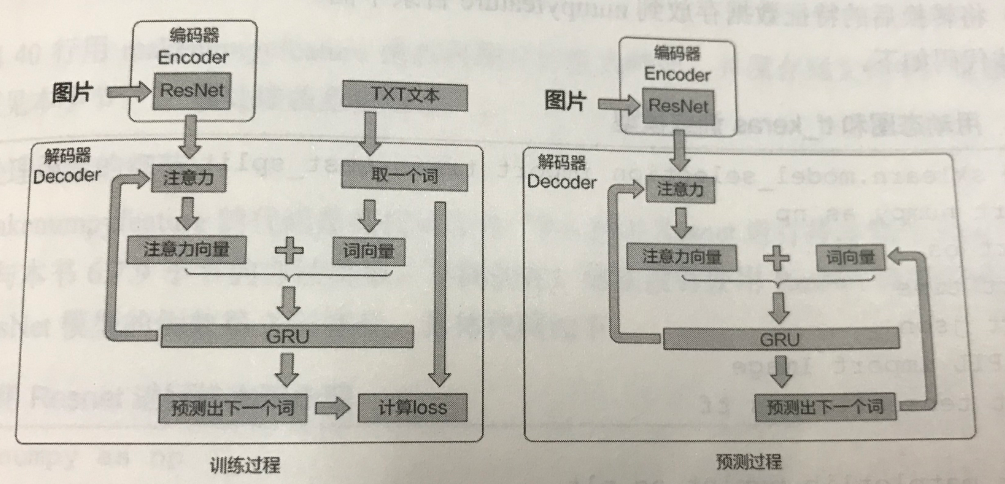

In [58]:
def create_rnn_cell(hidden_dim, cell_type):
    if cell_type == 'lstm':
        return tf.contrib.rnn.BasicLSTMCell(hidden_dim, state_is_tuple=True)
    elif cell_type == 'gru':
        return tf.contrib.rnn.GRUCell(hidden_dim)
    else:
        raise Exception("%s has not been supported" % cell_type)

def dropout(cell, keep_prob):
    return tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
#有vocab_size个词，他的词频大于等于3（10875个）img_feature_dim是维度
def get_train_model(vocab_size, img_feature_dim):
    #特征
    img_feature  = tf.placeholder(tf.float32, (batch_size, img_feature_dim))
    #句子
    sentence = tf.placeholder(tf.int32, (batch_size, num_timesteps))
    #weight 控制多少位是填充的
    mask = tf.placeholder(tf.float32, (batch_size, num_timesteps))
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    #指定train多少次
    global_step = tf.Variable(tf.zeros([], tf.int32), name='global_step', trainable=False)

    
    
    
    # Sets up the embedding layer.
    embedding_initializer = tf.random_uniform_initializer(-1.0, 1.0)
    with tf.variable_scope('embedding', initializer=embedding_initializer):
        embeddings = tf.get_variable(
            'embeddings',
            #embeddings是有着  vocab_size个(10875)  长和词向量大小（32）宽的东西
            [vocab_size,num_embedding_nodes],
            tf.float32)
        #将一个个词转化成embedding，是将sentense转成embendds
        embed_token_ids = tf.nn.embedding_lookup(embeddings, sentence[:, 0:num_timesteps-1])
        
        #对图像做embedding,他已经是embdding(2048的全连接)，我们要把他做成全连接弄成和word是相同的一个向量
    #这样才能拼接在一起，做预测
    img_feature_embed_init = tf.uniform_unit_scaling_initializer(factor=1.0)
    with tf.variable_scope('image_feature_embed', initializer=img_feature_embed_init):
        #弄成全连接的东西
        embed_img = tf.layers.dense(img_feature, num_embedding_nodes)
        #上面的词向量的形状（维度）embed_token_ids:[batch_size,num_timesteps-1,num_embedding_nodes]
        #image_feature:[batch_size,img_feature_dim]
        #图像的embedding是embed_img的维度是[batch_size,num_embedding_nodes]
        #所以我们要将他拼接起来，那就是要词向量的维度和embed_img弄成一样才行 
        embed_img = tf.expand_dims(embed_img, 1)
        #看下一个cell
        embed_inputs = tf.concat([embed_img, embed_token_ids], axis=1)
        
     
    # Sets up LSTM network.
    scale = 1.0 / math.sqrt(num_embedding_nodes + num_lstm_nodes[-1]) / 3.0
    lstm_init = tf.random_uniform_initializer(-scale, scale)
    with tf.variable_scope('lstm_nn', initializer=lstm_init):
        cells = []
        for i in range(num_lstm_layers):
            cell = create_rnn_cell(num_lstm_nodes[i], cell_type)
            cell = dropout(cell, keep_prob)
            cells.append(cell)
        cell = tf.contrib.rnn.MultiRNNCell(cells)
        
        #初始化状态
        initial_state = cell.zero_state(batch_size, tf.float32)
        # rnn_outputs: [batch_size, num_timesteps, hps.num_lstm_node[-1]]
        #中间状态不需要，把cell(也就是你要选择的RNN的模型)
        
        #这里不需要抗拒，LSTM是一种特殊的RNN，GRU也是, 
        #embed_input是 词向量 和 特征向量 的合体输进cell

        rnn_outputs, _ = tf.nn.dynamic_rnn(cell,
                                           embed_inputs,
                                           initial_state=initial_state)
        
        
        # Sets up the fully-connected layer.
    fc_init = tf.uniform_unit_scaling_initializer(factor=1.0)
    with tf.variable_scope('fc', initializer=fc_init):
        # 把rnn_outputs的中间的维度合并成一个维度
        rnn_outputs_2d = tf.reshape(rnn_outputs, [-1, num_lstm_nodes[-1]])
        
        #输入是rnn_outputs_2d，输出是num_fc_nodes
        fc1 = tf.layers.dense(rnn_outputs_2d, num_fc_nodes, name='fc1')
        fc1_dropout = tf.contrib.layers.dropout(fc1, keep_prob)
        fc1_relu = tf.nn.relu(fc1_dropout)
        #输入是fc1_dropout，输出是vocab_size
        logits = tf.layers.dense(fc1_dropout, vocab_size, name='logits')
     
    
    with tf.variable_scope('loss'):
         #展平
        sentence_flatten = tf.reshape(sentence, [-1])
         #展平
        mask_flatten = tf.reshape(mask, [-1])
         #这里暂时不知道,但是下面好多地方用到了这玩意，都去除以这东西了
        mask_sum = tf.reduce_sum(mask_flatten)
         #损失函数，做三件事，对logits进行softmax,第二件事情是对sentence_flatten进行one-hot编码
         #第三件事：计算啥没听懂
        softmax_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=sentence_flatten)
        
         #将softmax_loss和mask_flatten相乘
        weighted_softmax_loss = tf.multiply(softmax_loss, tf.cast(mask_flatten, tf.float32))
        loss = tf.reduce_sum(weighted_softmax_loss) / mask_sum
         #预测prediction
        prediction = tf.argmax(logits, 1, output_type = tf.int32)
         #计算有多少对的
        correct_prediction = tf.equal(prediction, sentence_flatten)
         #把对的值和mask进行相乘
        correct_prediction_with_mask = tf.multiply(tf.cast(correct_prediction, tf.float32),mask_flatten)
         #计算accuracy
        accuracy = tf.reduce_sum(correct_prediction_with_mask) / mask_sum
        
       
         #输入到tensorboard中去
        tf.summary.scalar('loss', loss)
        
        
      #定义train_op，和文本分类是类似的
    with tf.variable_scope('train_op'):
        #获取所有的可训练的变量
        tvars = tf.trainable_variables()
        for var in tvars:
            print("variable name: %s" % (var.name))
            
        #tf.gradients求导（梯度下降，对每个训练变量求偏导，每个方向都往下走）
        # 不超过clip_lstm_grads，防止梯度爆炸
        grads, _ = tf.clip_by_global_norm(
            tf.gradients(loss, tvars), clip_lstm_grads)
        
        for grad, var in zip(grads, tvars):
            tf.summary.histogram('%s_grad' % (var.name), grad)
            
        optimizer = tf.train.AdamOptimizer(learning_rate)
        
        #train_op就是用这个optimizer将梯度apply上去，#zip将变量和梯度绑定在一起，先记住着吧
        train_op = optimizer.apply_gradients(zip(grads, tvars), global_step=global_step)  
        
    return ((img_feature, sentence, mask, keep_prob),
            (loss, accuracy, train_op),
            global_step)



        

In [60]:
print(vocab_size)
print(img_feature_dim)


10875
2048


In [62]:
     

placeholders, metrics, global_step = get_train_model(vocab_size, img_feature_dim)
img_feature, sentence, mask, keep_prob = placeholders
loss, accuracy, train_op = metrics

summary_op = tf.summary.merge_all()

#用来保存模型，
saver = tf.train.Saver(max_to_keep=10)

TypeError: Error converting shape to a TensorShape: Dimension value must be integer or None or have an __index__ method, got value '(50,)' with type '<class 'tuple'>'.

### 到了这一步我已经不知道怎么办了，后面等懂了之后再来看吧

In [ ]:
  t1 = [[1, 2, 3], [4, 5, 6]]
  t2 = [[7, 8, 9], [10, 11, 12]]
  tf.concat([t1, t2], 0)  # [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]
  tf.concat([t1, t2], 1)  # [[1, 2, 3, 7, 8, 9], [4, 5, 6, 10, 11, 12]]


In [67]:
training_steps = 10000
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    writer = tf.summary.FileWriter(output_dir, sess.graph)
    for i in range(training_steps):
        #先获取数据
        batch_img_features, batch_sentence_ids, batch_weights, _ = caption_data.next(batch_size)
        input_vals = (batch_img_features, batch_sentence_ids, batch_weights, hps.keep_prob)
        
        feed_dict = dict(zip(placeholders, input_vals))
        fetches = [global_step, loss, accuracy, train_op]
        
        should_log = (i + 1) % log_frequent == 0
        should_save = (i + 1) % save_frequent == 0
        if should_log:
            fetches += [summary_op]
        outputs = sess.run(fetches, feed_dict)
        global_step_val, loss_val, accuracy_val = outputs[0:3]
        if should_log:
            summary_str = outputs[4]
            writer.add_summary(summary_str, global_step_val)
            logging.info('Step: %5d, loss: %3.3f, accuracy: %3.3f'
                         % (global_step_val, loss_val, accuracy_val))
        if should_save:
            logging.info("Step: %d, image caption model saved" % (global_step_val))
            saver.save(sess, os.path.join(output_dir, "image_caption"), global_step=global_step_val)
        

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'